In [34]:
!pip install opencv-python-headless numpy


In [35]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2025-12-30 10:24:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 104.21.88.156, 172.67.185.199, 2606:4700:3030::ac43:b9c7, ...
Connecting to pjreddie.com (pjreddie.com)|104.21.88.156|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.pjreddie.com/files/yolov3.weights [following]
--2025-12-30 10:24:41--  https://data.pjreddie.com/files/yolov3.weights
Resolving data.pjreddie.com (data.pjreddie.com)... 104.21.88.156, 172.67.185.199, 2606:4700:3030::ac43:b9c7, ...
Connecting to data.pjreddie.com (data.pjreddie.com)|104.21.88.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  82.7MB/s    in 2.9s    

2025-12-30 10:24:45 (82.7 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [36]:
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg


--2025-12-30 10:24:49--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg.1’

yolov3.cfg.1        100%[===================>]   8.15K  --.-KB/s    in 0s      

2025-12-30 10:24:49 (64.1 MB/s) - ‘yolov3.cfg.1’ saved [8342/8342]



In [38]:
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names   #this coco is a class here

--2025-12-30 10:24:59--  https://github.com/pjreddie/darknet/blob/master/data/coco.names
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘coco.names.2’

coco.names.2            [ <=>                ] 186.47K  --.-KB/s    in 0.04s   

2025-12-30 10:24:59 (4.91 MB/s) - ‘coco.names.2’ saved [190950]



In [39]:
from google.colab import files
upload=files.upload()

Saving images.jpg to images (1).jpg


In [40]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [41]:
#load yolo model
net=cv2.dnn.readNet('yolov3.weights','yolov3.cfg')

#load Coco names
with open('coco.names','r') as f:
  classes=f.read().strip().split("\n")

#get output layers
layer_names=net.getLayerNames()
output_layers=[layer_names[i-1] for i in net.getUnconnectedOutLayers()]

#Load Image
img=cv2.imread('images.jpg')
height,width,channels=img.shape

In [47]:
#create blob
blob=cv2.dnn.blobFromImage(img,1/255.0,(416,416),(0,0,0), swapRB=True,crop=False)

net.setInput(blob)
outputs=net.forward(output_layers)
boxes=[]
confidences=[]
class_ids=[]

In [48]:
#process detections
for output in outputs:
  for detection in output:
    scores=detection[5:]
    class_id=np.argmax(scores)
    confidence=scores[class_id]

    # Check if confidence is above a threshold and if it's a person (class_id 0)
    if confidence > 0.5 and class_id == 0: # Threshold can be adjusted
      center_x=int(detection[0]*width)
      center_y=int(detection[1]*height)
      w=int(detection[2]*width)
      h=int(detection[3]*height)
      x=int(center_x-w/2)
      y=int(center_y-h/2)
      boxes.append([x,y,w,h])
      confidences.append(float(confidence))
      class_ids.append(class_id) # Collect class_ids for each detected box

In [49]:
#detect only persons
if class_id==0:
  center_x=int(detection[0]*width)
  center_y=int(detection[1]*height)
  w=int(detection[2]*width)
  h=int(detection[3]*height)
  x=int(center_x-w/2)
  y=int(center_y-h/2)
  boxes.append([x,y,w,h])
  confidences.append(float(confidence))
  class_ids.append(class_id)

In [50]:
#apply nonmax supression
indices=cv2.dnn.NMSBoxes(boxes,confidences,0.5,0.4)

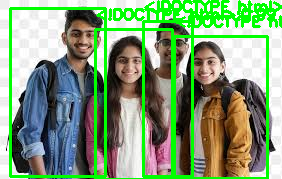

In [51]:
#draw bounding boxes
if len(indices) > 0:
  for i in indices:
    idx = i # NMSBoxes typically returns [[idx1], [idx2], ...] or [idx1, idx2, ...]
    x,y,w,h = boxes[idx]
    label = f"{classes[class_ids[idx]]}:{confidences[idx]:.2f}" # Use stored class_id and confidence for each box
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(img,label,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,
                0.5,(0,255,0),2)
  cv2_imshow(img) # Show image once after all boxes are drawn
  cv2.waitKey(0)
else:
  print("No objects detected to draw bounding boxes.")
  cv2_imshow(img) # Show original image even if no detections